# P1 Parallax

In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [ ]:
# Load the data; the x-y locations of the 2700 stars observed in June and December
june=np.load('june.npy')
december=np.load('december.npy')

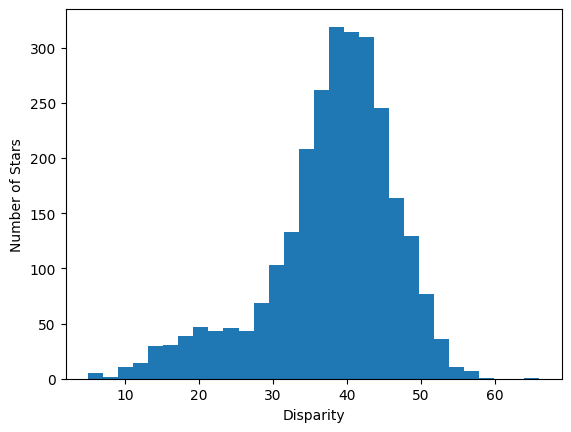

In [ ]:
# Compute the disparity along the x-axis and draw histogram.
diff = december[:, 0] - june[:, 0]
diff = diff[:,None]
plt.figure()
plt.hist(diff, bins=30)
plt.xlabel('Disparity')
plt.ylabel('Number of Stars')
plt.show()


In [ ]:
# Kmeans clustering code

class KMeans:
    def __init__(self, n_clusters, threshold=1e-7, max_iters=100):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.centroids = None
        self.threshold = threshold

    def initialize_centroids(self, X):
        # Randomly choose K data points as initial centroids
        # X: [# examples] x [# features]
        indices = np.random.choice(len(X), self.n_clusters, replace=False)
        return X[indices,:]

    def e_step(self, X):
        # Assign each data point to the nearest centroid
        clusters = []
        for point in X:
            distances = np.sqrt(np.sum((point - self.centroids)**2, axis=1))
            cluster = np.argmin(distances)
            clusters.append(cluster)
        return np.array(clusters)

    def m_step(self, X, clusters):
        # Calculate the new centroids as the mean of the assigned points
        new_centroids = []
        for i in range(self.n_clusters):
            cluster_points = X[clusters == i]
            if len(cluster_points) > 0:
                new_centroid = cluster_points.mean(axis=0)
            else:
                # Handle empty cluster by reinitializing to a random point
                new_centroid = X[np.random.choice(len(X))]
            new_centroids.append(new_centroid)
        return np.array(new_centroids)

    def fit(self, X):
        # Initialize centroids
        self.centroids = self.initialize_centroids(X)

        for i in range(self.max_iters):
            # Assign clusters based on current centroids
            clusters = self.e_step(X)

            # Update centroids based on the mean of the clusters
            new_centroids = self.m_step(X, clusters)

            # Check for convergence (if centroids do not change)
            if np.all(np.abs(self.centroids - new_centroids) < self.threshold):
                print('Converged at the {}-th iteration.'.format(i))
                break
            if i == self.max_iters-1:
                print('Failed to converge.')

            self.centroids = new_centroids



        return self.centroids, clusters

    def predict(self, X):
        return self.assign_clusters(X)



In [ ]:
# Let's perform clustering

# Initialize KMeans
kmeans = KMeans(n_clusters=2, max_iters=1000)

# Fit the model
centroids, clusters = kmeans.fit(diff)

# # Print the results
print("Centroids:\n", centroids)
print("Clusters:\n", clusters)



Converged at the 1-th iteration.
Centroids:
 [[25.45292208]
 [41.53454894]]
Clusters:
 [1 1 1 ... 1 1 1]


In [ ]:
import numpy as np
from scipy.stats import norm

class UnivariateGaussianMixtureModel:
    def __init__(self, n_components, threshold=1e-7, max_iters=100):
        self.n_components = n_components
        self.threshold = threshold
        self.max_iters = max_iters
        self.means = None
        self.variances = None
        self.weights = None
        self.responsibilities = None

    def initialize_parameters(self, X):
        # Initialize means, variances, and weights
        n_samples = X.shape[0]
        n_features = X.shape[1]

        # Randomly choose initial means from the data points
        indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[indices]

        # Initialize variances to the variance of the data
        self.variances = np.full(self.n_components, np.var(X))

        # Initialize weights uniformly
        self.weights = np.full(self.n_components, 1 / self.n_components)

    def e_step(self, X):
        n_samples = len(X)
        self.responsibilities = np.zeros((n_samples, self.n_components))

        # Compute the responsibilities
        for k in range(self.n_components):
            pdf = norm.pdf(X, loc=self.means[k, :], scale=np.sqrt(self.variances[k]))
            self.responsibilities[:, k] = self.weights[k] * np.squeeze(pdf)

        # Normalize the responsibilities across all components
        self.responsibilities /= self.responsibilities.sum(axis=1, keepdims=True)+1e-10

    def m_step(self, X):
        n_samples = len(X)
        # Update the weights, means, and variances
        N_k = self.responsibilities.sum(axis=0, keepdims=True).T+1e-10  # Effective number of samples assigned to each component


        self.weights = N_k / n_samples
        self.means = np.dot(self.responsibilities.T, X) / N_k

        for k in range(self.n_components):
            diff = X - self.means[k]
            self.variances[k] = ((self.responsibilities[:, k, None]*diff).T@diff) / N_k[k]

    def fit(self, X):
        # Initialize parameters
        self.initialize_parameters(X)

        log_likelihood_old = 0

        for i in range(self.max_iters):
            # E-step: Calculate responsibilities
            self.e_step(X)

            # M-step: Update parameters
            self.m_step(X)

            # Check for convergence by comparing log-likelihoods
            log_likelihood_new = np.sum(np.log(np.dot(self.responsibilities, self.weights)))

            if abs(log_likelihood_new - log_likelihood_old) < self.threshold:
                print('Converged at the {}-th iteration.'.format(i))
                break
            if i == self.max_iters-1:
                print('Failed to converge.')

            log_likelihood_old = log_likelihood_new
        return self.means, self.variances, self.weights

    def predict_proba(self, X):
        n_samples = len(X)
        probs = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            probs[:, k] = self.weights[k] * norm.pdf(X, loc=self.means[k], scale=np.sqrt(self.variances[k]))

        probs /= probs.sum(axis=1, keepdims=True)
        return probs

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


ugmm=UnivariateGaussianMixtureModel(n_components=2, max_iters=1000)
means, variances, weights = ugmm.fit(diff)
print("Means:\n", means)
print("Variances:\n", variances)
print("Weights:\n", weights)

# I eyeballed the histogram and did my own guess. Based on my guesswork,
# I think the left Gaussian's mode is around 20, which matches GMM's result.
# Remember, KMeans result is with a centroid 25.45, which is biased toward the other mean.

<ipython-input-8-923defa157ed>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.variances[k] = ((self.responsibilities[:, k, None]*diff).T@diff) / N_k[k]
<ipython-input-8-923defa157ed>:68: RuntimeWarning: divide by zero encountered in log
  log_likelihood_new = np.sum(np.log(np.dot(self.responsibilities, self.weights)))


Converged at the 415-th iteration.
Means:
 [[40.15282903]
 [20.84323758]]
Variances:
 [34.14182055 34.45939002]
Weights:
 [[0.88154726]
 [0.11845272]]


## P2 PCA and DCT

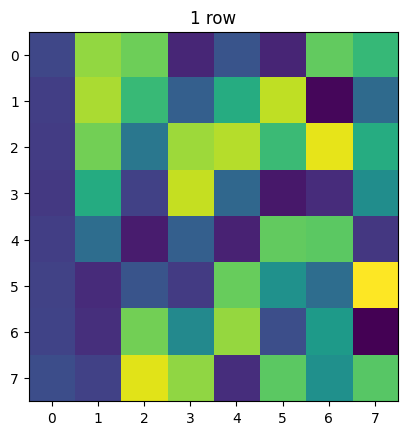

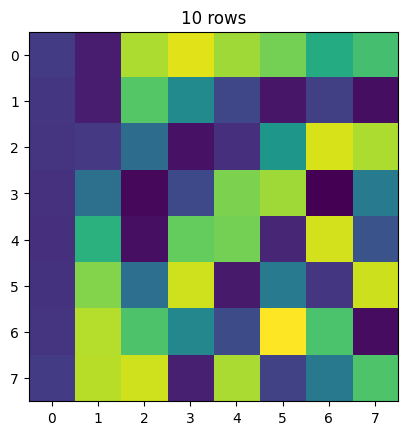

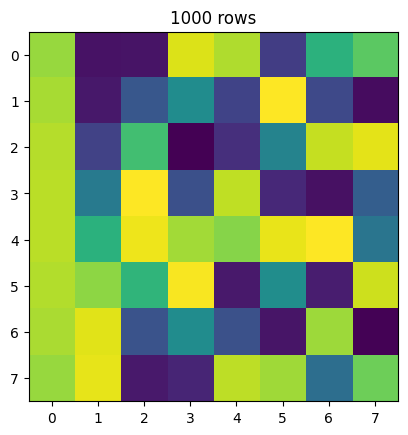

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

# Read the image
X = cv2.imread('siebel.jpg')

# Convert to double and center the data by subtracting 128
X = X.astype(np.float64) - 128
X = np.mean(X, axis=2)



n_rows = 8


rowIdx1 = np.random.randint(0, X.shape[0] - n_rows, 1)
rowIdx10 = np.random.randint(0, X.shape[0] - n_rows, 10)
rowIdx1000 = np.random.randint(0, X.shape[0] - n_rows, 1000)

# Initialize the transformed arrays
X1 = np.zeros((n_rows, X.shape[1] * len(rowIdx1)))
X10 = np.zeros((n_rows, X.shape[1] * len(rowIdx10)))
X1000 = np.zeros((n_rows, X.shape[1] * len(rowIdx1000)))

for ii in range(len(rowIdx1)):
    X1[:, ii * X.shape[1]:(ii + 1) * X.shape[1]] = X[rowIdx1[ii]:rowIdx1[ii] + n_rows, :]
for ii in range(len(rowIdx10)):
    X10[:, ii * X.shape[1]:(ii + 1) * X.shape[1]] = X[rowIdx10[ii]:rowIdx10[ii] + n_rows, :]
for ii in range(len(rowIdx1000)):
    X1000[:, ii * X.shape[1]:(ii + 1) * X.shape[1]] = X[rowIdx1000[ii]:rowIdx1000[ii] + n_rows, :]


# Subtract the mean for each row
X1 -= np.mean(X1, axis=1, keepdims=True)
X10 -= np.mean(X10, axis=1, keepdims=True)
X1000 -= np.mean(X1000, axis=1, keepdims=True)

# Compute the covariance matrices
C1 = np.cov(X1)
C10 = np.cov(X10)
C1000 = np.cov(X1000)

# Compute the eigenvectors
V1, U1 = np.linalg.eig(C1)
V10, U10 = np.linalg.eig(C10)
V1000, U1000 = np.linalg.eig(C1000)

# Plot the results
plt.figure()
plt.imshow(U1, aspect='equal')
plt.title('1 row')

plt.figure()
plt.title('10 rows')
plt.imshow(U10, aspect='equal')


plt.figure()
plt.title('1000 rows')
plt.imshow(U1000, aspect='equal')

# P3 Instantaneous Source Separation

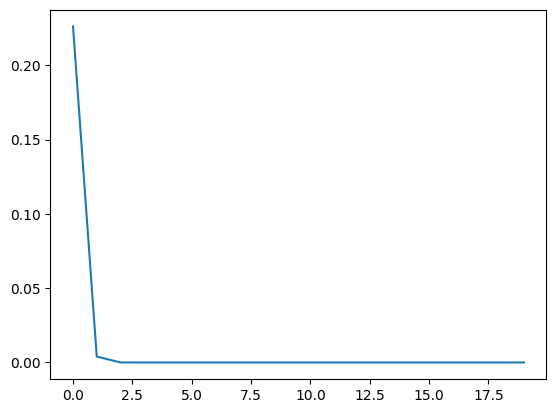

(20, 20)


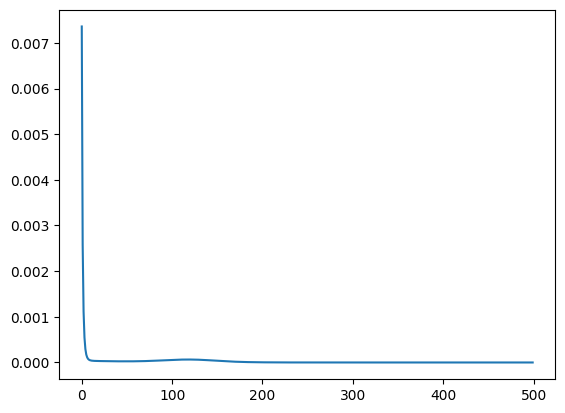

In [ ]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import IPython.display as ipd

# Load the audio files into a 20 x [time samples] matrix
x = []
for ii in range(1,21):
    data, rate = sf.read('x_ica_{}.wav'.format(ii))
    x.append(data)
x = np.array(x)

# Compute covariance matrix and its eigenvalues/eigenvectors
cov_matrix = np.cov(x)
V, U = np.linalg.eig(cov_matrix)
# print(V.shape)

# Plot the eigenvalues
plt.figure()
plt.plot(V)
plt.show()

# Whiten the data
W = U / np.sqrt(V[None,:])
print(W.shape)
z = W[:, :3].T@x


# ICA Implementation
Wica = np.eye(3)
rho = 0.000001
maxIter = 500
dWSum = np.zeros(maxIter)
l = z.shape[1]

for ii in range(maxIter):
    y = Wica@z
    dW = rho * (l * np.eye(3) - np.dot(np.tanh(y), np.power(y, 3).T)) @ Wica
    Wica += dW
    dWSum[ii] = np.sum(dW ** 2)

# Plot the convergence curve
plt.figure()
plt.plot(dWSum)
plt.show()


In [ ]:
ipd.Audio(z[2, :], rate=rate)

In [ ]:
ipd.Audio(z[1, :], rate=rate)

In [ ]:
ipd.Audio(z[0, :], rate=rate)

In [ ]:

ipd.Audio(y[0, :], rate=rate)


In [ ]:
ipd.Audio(y[1, :], rate=rate)

In [ ]:
ipd.Audio(y[2, :], rate=rate)

# P4 Single Channel Source Separation: NMF

In [ ]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import IPython.display as ipd




In [ ]:


def nmf(X, K, maxIter=500):
    F, T = X.shape

    # Initialize W and H with random values
    W = np.random.rand(F, K)
    H = np.random.rand(K, T)

    err = []

    eps = 1e-10

    for ii in range(maxIter):
        # Update W and H
        W = W * (np.abs(X) @ H.T) / (W @ H @ H.T + eps)
        H = H * (W.T @ np.abs(X)) / (W.T @ W @ H + eps)

        # Compute the reconstruction error
        error = np.trace((X - W @ H) @ (X - W @ H).T)
        err.append(error)

    # Plot the error
    plt.figure()
    plt.plot(err)
    plt.xlabel('Iteration')
    plt.ylabel('Reconstruction Error')
    plt.title('NMF Error Over Iterations')
    plt.show()

    return W, H

In [ ]:

def nmf_sep(X, Ws, Wn, maxIter=100):
    F, T = X.shape

    # Initialize H with random values
    H = np.random.rand(Ws.shape[1] + Wn.shape[1], T)

    err = []

    eps = 1e-10

    for ii in range(maxIter):
        # Update H
        H = H * ( np.hstack((Ws, Wn)).T @ np.abs(X)) / ( ( np.hstack((Ws, Wn)).T @ (np.hstack((Ws, Wn))@H) ) + eps)

        # Compute the reconstruction error
        error = np.trace(((X - np.hstack((Ws, Wn))@H)@(X - np.hstack((Ws, Wn))@H).T))
        err.append(error)

    # Plot the error
    plt.figure()
    plt.plot(err)
    plt.xlabel('Iteration')
    plt.ylabel('Reconstruction Error')
    plt.title('NMF Separation Error Over Iterations')
    plt.show()

    return H


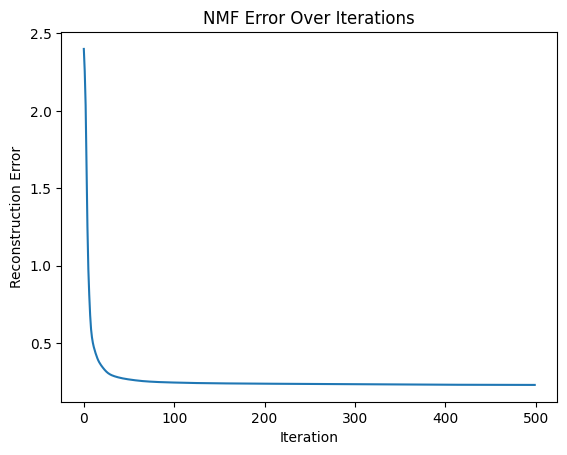

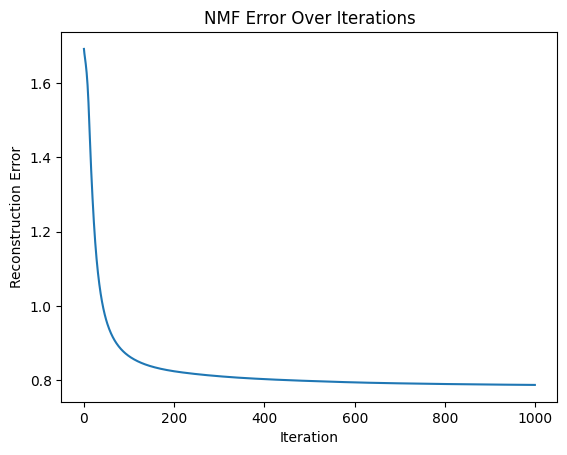

In [ ]:
import scipy.signal as signal

trs, rate = sf.read('trs.wav')
trn, rate = sf.read('trn.wav')
tex, rate = sf.read('x_nmf.wav')

sz = 1024
hp = 512

wn = np.hanning(sz)**0.5

# Compute STFTs
_, _, trS = signal.stft(trs, fs=rate, window='hann', nperseg=sz, noverlap=sz-hp, nfft=sz)
_, _, trN = signal.stft(trn, fs=rate, window='hann', nperseg=sz, noverlap=sz-hp, nfft=sz)
_, _, teX = signal.stft(tex, fs=rate, window='hann', nperseg=sz, noverlap=sz-hp, nfft=sz)

# NMF on the magnitude spectra
Ws, _ = nmf(np.abs(trS), 30)
Wn, _ = nmf(np.abs(trN), 30, maxIter=1000)



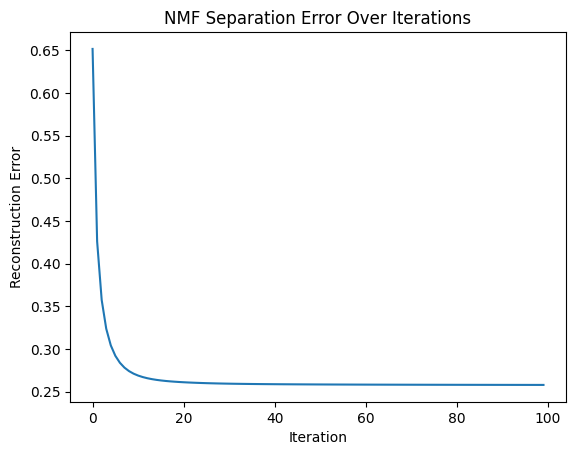

In [ ]:
H = nmf_sep(np.abs(teX), Ws, Wn)

# Reconstruct the separated signals
_, rs = signal.istft((Ws @ H[:30, :]) * teX/np.abs(teX), fs=rate, window='hann', nperseg=None, noverlap=sz-hp, nfft=sz)
_, rn = signal.istft((Wn @ H[30:, :]) * teX/np.abs(teX), fs=rate, window='hann', nperseg=None, noverlap=sz-hp, nfft=sz)

In [ ]:
ipd.Audio(rs, rate=rate)

In [ ]:
ipd.Audio(rn, rate=rate)